In [1]:
%matplotlib inline

import os
import sys
import time

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfd = tf.contrib.distributions
layers = tf.keras.layers

tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.12.0
Eager execution: True


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [3]:
X = x_train > 0.5
X = X.astype('float32')

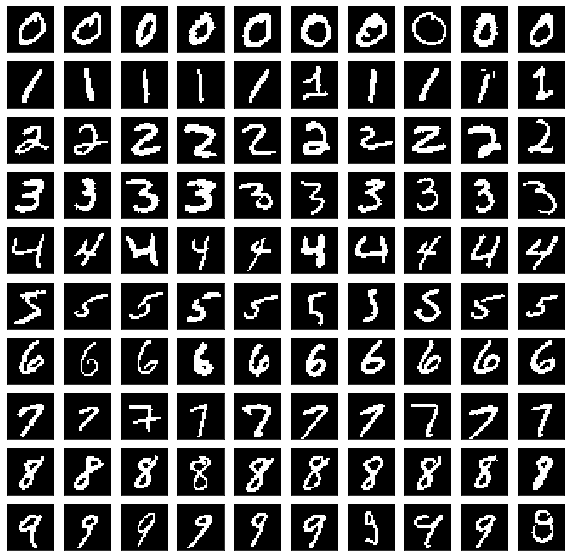

In [4]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  imgs = X[np.where(y_train == i)[0][:10]]
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(imgs[j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [5]:
class MaskedConv2D(layers.Conv2D):
  def __init__(self, mask_type='A', *args, **kwargs):
    super(MaskedConv2D, self).__init__(*args, **kwargs)
    self.mask_type = mask_type

  def call(self, inputs):
    kernel_h, kernel_w = self.kernel_size
    center_h = kernel_h // 2
    center_w = kernel_w // 2
    
    weights = self.kernel
    mask = np.ones_like(weights.numpy(), dtype='float32')
    #print(weights.shape, mask.shape)
    
    # kernel shape: [kernel_h, kernel_w, size_in, size_out]
    mask[center_h+1:, :, :, :] = 0.0
    mask[center_h:, center_w+1:, :, :] = 0.0
    
    if self.mask_type == 'A':
      mask[center_h,center_w,:,:] = 0.0

    weights = tf.math.multiply(weights, mask)
    
    outputs = self._convolution_op(inputs, weights)

    if self.data_format == 'channels_first':
        outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
    else:
        outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')

    if self.activation is not None:
        return self.activation(outputs)
    return outputs
  
layer = MaskedConv2D(
    filters=64, kernel_size=5, mask_type='A', padding='SAME', activation=None)
# print(layer(tf.zeros([1,28,28,1])))
# print(layer.variables)

In [6]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.conv2b = MaskedConv2D(
        filters=filters2, kernel_size=kernel_size, padding='same')
    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))

  def call(self, input_tensor):
    x = self.conv2a(input_tensor)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = tf.nn.relu(x)

    x = self.conv2c(x)

    x += input_tensor
    return tf.nn.relu(x)

feature_map_size_RES = 128
filters = [feature_map_size_RES, feature_map_size_RES, 2*feature_map_size_RES]    
block = ResnetIdentityBlock(3, filters)
# print(block(tf.zeros([1, 2, 3, 2*feature_map_size_RES])))
# print([x.name for x in block.variables])


In [7]:
class PixelCNN(tf.keras.Model):
  def __init__(self, num_layers=15, h_residual=128, h_maskB=32):
    super(PixelCNN, self).__init__(name='')
    self.num_layers = num_layers
    
    # mask A, 7*7
    self.first_layer = MaskedConv2D(
        filters=2*h_residual, kernel_size=7, mask_type='A', padding='SAME', activation=None)
    
    # mask B, 3*3, num_layers=15, h_residual
    filters = [h_residual, h_residual, 2*h_residual]    
    self.res_block = ResnetIdentityBlock(3, filters)
    
    # mask B, 1*1, num_layers=2, h_maskB, Relu
    self.conv_1by1_a = tf.keras.layers.Conv2D(h_maskB, (1, 1))
    self.conv_1by1_b = tf.keras.layers.Conv2D(1, (1, 1))
    
  def call(self, input_tensor):
    x = self.first_layer(input_tensor)
    
    for i in range(self.num_layers):
      x = self.res_block(x)
      
    x = self.conv_1by1_a(x)
    x = tf.nn.relu(x)
    x = self.conv_1by1_b(x)
    #x = tf.nn.sigmoid(x)
    
    return x

pixel_cnn = PixelCNN(num_layers=15, h_residual=128, h_maskB=32)
output_img = pixel_cnn(tf.zeros([1,28,28,1]))
#print(pixel_cnn(tf.zeros([1,28,28,1])))
#print(pixel_cnn.variables)

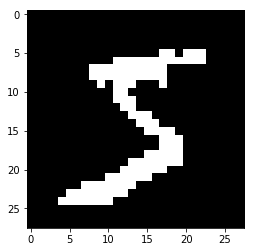

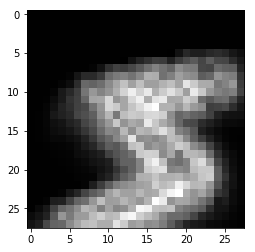

In [8]:
sample = X[0]
sample_in = sample[np.newaxis, :, :, np.newaxis]

output_img = pixel_cnn(tf.constant(sample_in))
plt.imshow(np.squeeze(sample), cmap='Greys_r'); plt.show()
plt.imshow(np.squeeze(output_img), cmap='Greys_r'); plt.show()

In [9]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sigmoid_cross_entropy(multi_class_labels=y, logits=y_)

sample_img = X[0:3]
sample_img = sample_img[:, :, :, np.newaxis]
l = loss(pixel_cnn, sample_img, sample_img)
print("Loss test: {}".format(l))

Loss test: 0.7610191106796265


In [10]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [11]:
global_step = tf.Variable(0)

loss_value, grads = grad(pixel_cnn, sample_img, sample_img)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))


Step: 0, Initial Loss: 0.7610191106796265


In [12]:
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(60000).batch(batch_size)

In [13]:
def generate(num_samples):
    samples = np.zeros((num_samples, 28, 28, 1), dtype='float32')

    for i in range(28):
      for j in range(28):
        for k in range(1):
          next_sample_logit = pixel_cnn(samples)
          next_sample_sgmd = tf.nn.sigmoid(next_sample_logit)
          next_sample_prob = np.random.binomial(1, next_sample_sgmd)
          samples[:, i, j, k] = next_sample_prob[:, i, j, k]

    return samples

def generate_with_samples(samples_in):
    samples_out = pixel_cnn(samples_in)
    return samples_out

In [14]:
# ref: https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(10,1))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        #a.set_title(title)
        a.set_axis_off()
    #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

Epoch 000 Iter 000: Loss: 0.7493895888


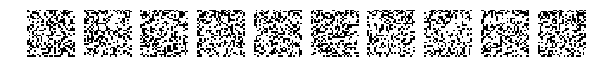

Epoch 000 Iter 500: Loss: 0.2415626636


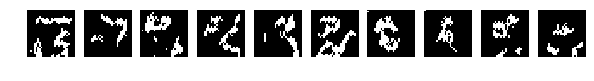

Epoch 000 Iter 1000: Loss: 0.1831634248


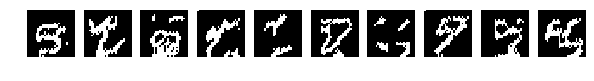

Epoch 000 Iter 1500: Loss: 0.1604237103


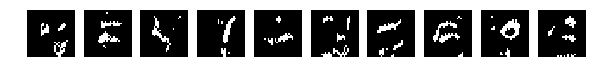

Epoch 000 Iter 2000: Loss: 0.1470988599


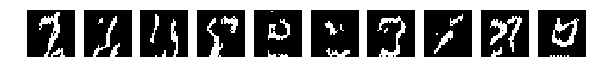

Epoch 000 Iter 2500: Loss: 0.1378809780


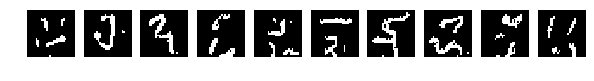

Epoch 000 Iter 3000: Loss: 0.1309787385


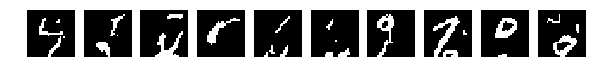

Epoch 000 Iter 3500: Loss: 0.1256273208


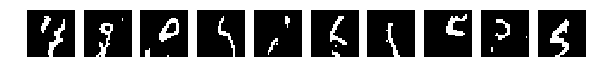

Epoch 000: Loss: 0.1233900977


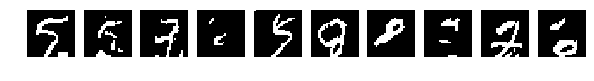

Epoch 001 Iter 000: Loss: 0.0929622650
Epoch 001 Iter 500: Loss: 0.0909022217
Epoch 001 Iter 1000: Loss: 0.0903627876
Epoch 001 Iter 1500: Loss: 0.0901063903
Epoch 001 Iter 2000: Loss: 0.0898340416
Epoch 001 Iter 2500: Loss: 0.0895182855
Epoch 001 Iter 3000: Loss: 0.0892702844
Epoch 001 Iter 3500: Loss: 0.0890241750
Epoch 001: Loss: 0.0889364592


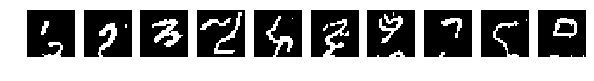

Epoch 002 Iter 000: Loss: 0.0869659409
Epoch 002 Iter 500: Loss: 0.0869647412
Epoch 002 Iter 1000: Loss: 0.0869828810
Epoch 002 Iter 1500: Loss: 0.0868034983
Epoch 002 Iter 2000: Loss: 0.0866579225
Epoch 002 Iter 2500: Loss: 0.0864721173
Epoch 002 Iter 3000: Loss: 0.0864163265
Epoch 002 Iter 3500: Loss: 0.0863684082
Epoch 002: Loss: 0.0863355051


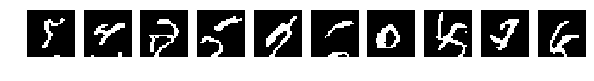

Epoch 003 Iter 000: Loss: 0.0824339911
Epoch 003 Iter 500: Loss: 0.0853752104
Epoch 003 Iter 1000: Loss: 0.0852507420
Epoch 003 Iter 1500: Loss: 0.0851750658
Epoch 003 Iter 2000: Loss: 0.0851398315
Epoch 003 Iter 2500: Loss: 0.0850145927
Epoch 003 Iter 3000: Loss: 0.0849137951
Epoch 003 Iter 3500: Loss: 0.0849156285
Epoch 003: Loss: 0.0849107992


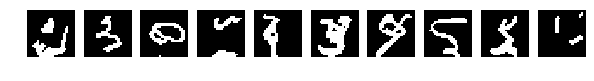

Epoch 004 Iter 000: Loss: 0.0860427618
Epoch 004 Iter 500: Loss: 0.0839330396
Epoch 004 Iter 1000: Loss: 0.0839530593
Epoch 004 Iter 1500: Loss: 0.0839086684
Epoch 004 Iter 2000: Loss: 0.0839355796
Epoch 004 Iter 2500: Loss: 0.0839626760
Epoch 004 Iter 3000: Loss: 0.0839575630
Epoch 004 Iter 3500: Loss: 0.0839325632
Epoch 004: Loss: 0.0839556401


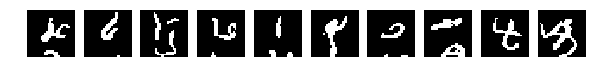

Epoch 005 Iter 000: Loss: 0.0816609338
Epoch 005 Iter 500: Loss: 0.0836229759
Epoch 005 Iter 1000: Loss: 0.0832934403
Epoch 005 Iter 1500: Loss: 0.0833955268
Epoch 005 Iter 2000: Loss: 0.0833289092
Epoch 005 Iter 2500: Loss: 0.0833567362
Epoch 005 Iter 3000: Loss: 0.0833105088
Epoch 005 Iter 3500: Loss: 0.0832644010
Epoch 005: Loss: 0.0832278737


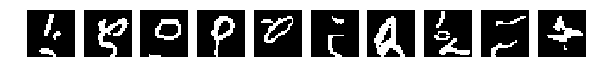

Epoch 006 Iter 000: Loss: 0.0867513716
Epoch 006 Iter 500: Loss: 0.0828490194
Epoch 006 Iter 1000: Loss: 0.0829216454
Epoch 006 Iter 1500: Loss: 0.0827826829
Epoch 006 Iter 2000: Loss: 0.0826715826
Epoch 006 Iter 2500: Loss: 0.0827035058
Epoch 006 Iter 3000: Loss: 0.0826807616
Epoch 006 Iter 3500: Loss: 0.0826276319
Epoch 006: Loss: 0.0826426302


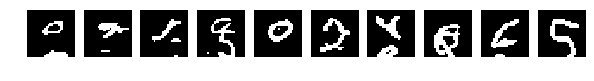

Epoch 007 Iter 000: Loss: 0.0775771737
Epoch 007 Iter 500: Loss: 0.0821683553
Epoch 007 Iter 1000: Loss: 0.0820467276
Epoch 007 Iter 1500: Loss: 0.0821184741
Epoch 007 Iter 2000: Loss: 0.0820783730
Epoch 007 Iter 2500: Loss: 0.0821143375
Epoch 007 Iter 3000: Loss: 0.0821644653
Epoch 007 Iter 3500: Loss: 0.0821290979
Epoch 007: Loss: 0.0821283274


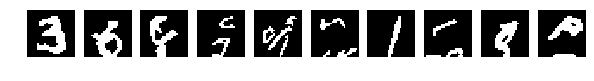

Epoch 008 Iter 000: Loss: 0.0764751956
Epoch 008 Iter 500: Loss: 0.0815270637
Epoch 008 Iter 1000: Loss: 0.0817554616
Epoch 008 Iter 1500: Loss: 0.0817684818
Epoch 008 Iter 2000: Loss: 0.0817755370
Epoch 008 Iter 2500: Loss: 0.0817486553
Epoch 008 Iter 3000: Loss: 0.0817257732
Epoch 008 Iter 3500: Loss: 0.0817237706
Epoch 008: Loss: 0.0816936714


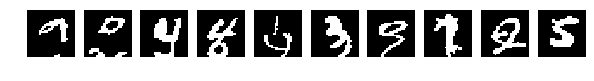

Epoch 009 Iter 000: Loss: 0.0735514015
Epoch 009 Iter 500: Loss: 0.0813298797
Epoch 009 Iter 1000: Loss: 0.0811979286
Epoch 009 Iter 1500: Loss: 0.0812207776
Epoch 009 Iter 2000: Loss: 0.0812674919
Epoch 009 Iter 2500: Loss: 0.0813073120
Epoch 009 Iter 3000: Loss: 0.0813195475
Epoch 009 Iter 3500: Loss: 0.0813088104
Epoch 009: Loss: 0.0813056252


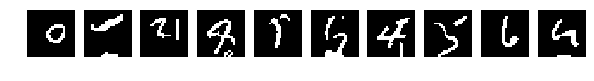

Epoch 010 Iter 000: Loss: 0.0773836747
Epoch 010 Iter 500: Loss: 0.0809307135
Epoch 010 Iter 1000: Loss: 0.0810723600
Epoch 010 Iter 1500: Loss: 0.0810010792
Epoch 010 Iter 2000: Loss: 0.0810086044
Epoch 010 Iter 2500: Loss: 0.0809487263
Epoch 010 Iter 3000: Loss: 0.0809881620
Epoch 010 Iter 3500: Loss: 0.0809964740
Epoch 010: Loss: 0.0809595666


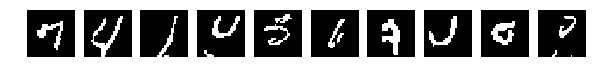

Epoch 011 Iter 000: Loss: 0.0729552954
Epoch 011 Iter 500: Loss: 0.0804855372
Epoch 011 Iter 1000: Loss: 0.0804828454
Epoch 011 Iter 1500: Loss: 0.0806365249
Epoch 011 Iter 2000: Loss: 0.0806677925
Epoch 011 Iter 2500: Loss: 0.0806692335
Epoch 011 Iter 3000: Loss: 0.0806517936
Epoch 011 Iter 3500: Loss: 0.0806204161
Epoch 011: Loss: 0.0806320640


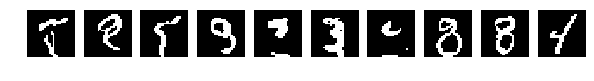

Epoch 012 Iter 000: Loss: 0.0763974488
Epoch 012 Iter 500: Loss: 0.0804935254
Epoch 012 Iter 1000: Loss: 0.0801489723
Epoch 012 Iter 1500: Loss: 0.0802313674
Epoch 012 Iter 2000: Loss: 0.0802998102
Epoch 012 Iter 2500: Loss: 0.0803206352
Epoch 012 Iter 3000: Loss: 0.0803149021
Epoch 012 Iter 3500: Loss: 0.0803266475
Epoch 012: Loss: 0.0803351331


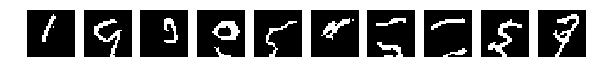

Epoch 013 Iter 000: Loss: 0.0828502327
Epoch 013 Iter 500: Loss: 0.0803138234
Epoch 013 Iter 1000: Loss: 0.0801809147
Epoch 013 Iter 1500: Loss: 0.0800128805
Epoch 013 Iter 2000: Loss: 0.0799969583
Epoch 013 Iter 2500: Loss: 0.0800366143
Epoch 013 Iter 3000: Loss: 0.0800452293
Epoch 013 Iter 3500: Loss: 0.0800757880
Epoch 013: Loss: 0.0800600081


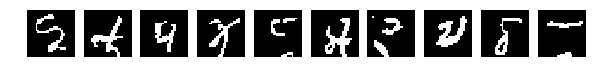

Epoch 014 Iter 000: Loss: 0.0783227682
Epoch 014 Iter 500: Loss: 0.0799525327
Epoch 014 Iter 1000: Loss: 0.0799696515
Epoch 014 Iter 1500: Loss: 0.0800241222
Epoch 014 Iter 2000: Loss: 0.0800273904
Epoch 014 Iter 2500: Loss: 0.0799493258
Epoch 014 Iter 3000: Loss: 0.0798714703
Epoch 014 Iter 3500: Loss: 0.0798087521
Epoch 014: Loss: 0.0798014982


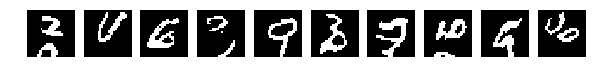

Epoch 015 Iter 000: Loss: 0.0806552693
Epoch 015 Iter 500: Loss: 0.0792770671
Epoch 015 Iter 1000: Loss: 0.0793047715
Epoch 015 Iter 1500: Loss: 0.0794629470
Epoch 015 Iter 2000: Loss: 0.0795538947
Epoch 015 Iter 2500: Loss: 0.0796029097
Epoch 015 Iter 3000: Loss: 0.0795976548
Epoch 015 Iter 3500: Loss: 0.0795770920
Epoch 015: Loss: 0.0795487862


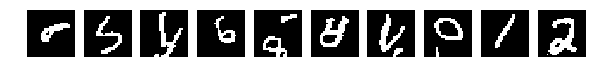

Epoch 016 Iter 000: Loss: 0.0763584748
Epoch 016 Iter 500: Loss: 0.0791056008
Epoch 016 Iter 1000: Loss: 0.0792606244
Epoch 016 Iter 1500: Loss: 0.0791594093
Epoch 016 Iter 2000: Loss: 0.0792061092
Epoch 016 Iter 2500: Loss: 0.0791990053
Epoch 016 Iter 3000: Loss: 0.0792837479
Epoch 016 Iter 3500: Loss: 0.0793029749
Epoch 016: Loss: 0.0793002671


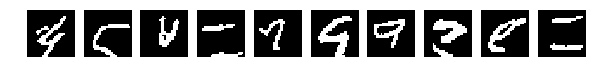

Epoch 017 Iter 000: Loss: 0.0813705176
Epoch 017 Iter 500: Loss: 0.0790334611
Epoch 017 Iter 1000: Loss: 0.0790820235
Epoch 017 Iter 1500: Loss: 0.0790092057
Epoch 017 Iter 2000: Loss: 0.0790509995
Epoch 017 Iter 2500: Loss: 0.0790212041
Epoch 017 Iter 3000: Loss: 0.0790383688
Epoch 017 Iter 3500: Loss: 0.0790974248
Epoch 017: Loss: 0.0790854889


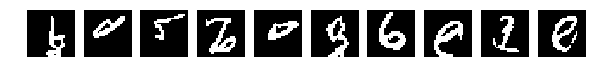

Epoch 018 Iter 000: Loss: 0.0832753256
Epoch 018 Iter 500: Loss: 0.0791489533
Epoch 018 Iter 1000: Loss: 0.0787198559
Epoch 018 Iter 1500: Loss: 0.0788148567
Epoch 018 Iter 2000: Loss: 0.0788853467
Epoch 018 Iter 2500: Loss: 0.0788781804
Epoch 018 Iter 3000: Loss: 0.0789322162
Epoch 018 Iter 3500: Loss: 0.0788858813
Epoch 018: Loss: 0.0788782861


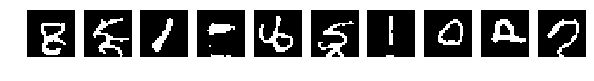

Epoch 019 Iter 000: Loss: 0.0806797668
Epoch 019 Iter 500: Loss: 0.0787080873
Epoch 019 Iter 1000: Loss: 0.0787310323
Epoch 019 Iter 1500: Loss: 0.0786742628
Epoch 019 Iter 2000: Loss: 0.0786978345
Epoch 019 Iter 2500: Loss: 0.0787130070
Epoch 019 Iter 3000: Loss: 0.0786675083
Epoch 019 Iter 3500: Loss: 0.0786915557
Epoch 019: Loss: 0.0786938425


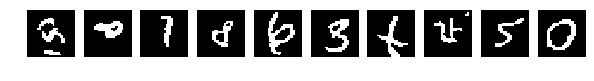

In [15]:
# keep results for plotting
train_loss_results = []

num_epochs = 20
learning_rate=tf.train.exponential_decay(
            learning_rate=0.0001,
            decay_steps=100,
            global_step=tf.train.get_or_create_global_step(),
            decay_rate=0.94)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)

for epoch in range(num_epochs):
  epoch_loss_avg = tf.contrib.eager.metrics.Mean()

  # Training loop 
  for i, x in enumerate(dataset):
    # Optimize the model
    batch_x = x[:, :, :, np.newaxis]
    batch_y = batch_x.numpy()
    loss_value, grads = grad(pixel_cnn, batch_x, batch_y)
    optimizer.apply_gradients(zip(grads, pixel_cnn.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    
    if i % 500 == 0:
      print("Epoch {:03d} Iter {:03d}: Loss: {:.10f}".format(epoch, i, epoch_loss_avg.result()))
    
      if epoch == 0:
        result = generate(10)
        show_images(np.squeeze(result))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  print("Epoch {:03d}: Loss: {:.10f}".format(epoch, epoch_loss_avg.result()))

  result = generate(10)
  show_images(np.squeeze(result))

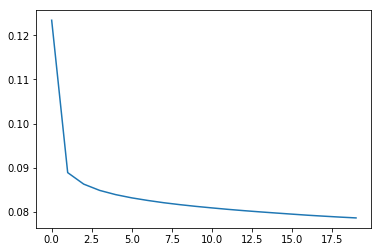

In [16]:
plt.plot(train_loss_results)

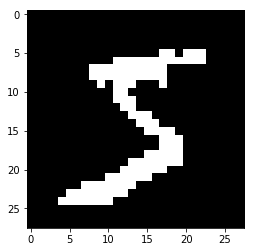

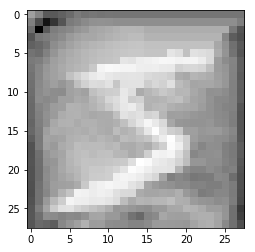

In [17]:
sample_in = X[0]
sample_in = sample_in[np.newaxis, :, :, np.newaxis]
sample_out = generate_with_samples(sample_in)

plt.imshow(np.squeeze(sample_in), cmap='Greys_r'); plt.show()
plt.imshow(np.squeeze(sample_out), cmap='Greys_r'); plt.show()

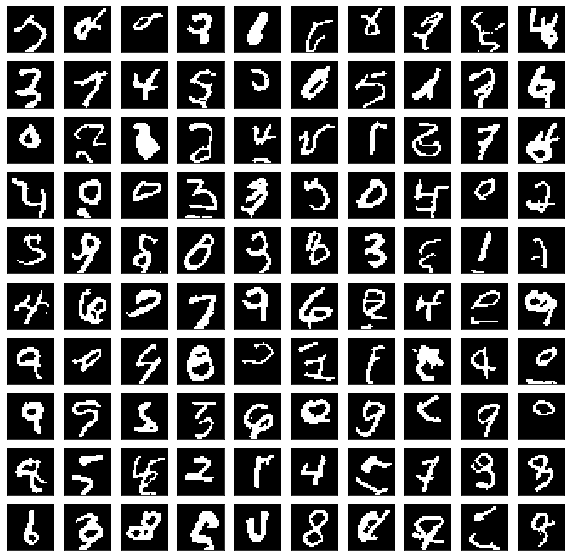

In [18]:
result = generate(100)

rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(np.squeeze(result[i*10+j]), cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [19]:
print('Done')

Done
